## Libraries

In [38]:
# Determinadas.
import numpy as np
import pandas
import matplotlib.pyplot as plt
import random

# Preprocesamientos.
from sklearn import preprocessing

# Modelos.
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Procesamiento de imágenes.
import numpy as np
import cv2
import os
from numpy import mean
from numpy import std

# Control de modelos.
from joblib import dump, load

# Distancia de Levenshtein.
from Levenshtein import distance as lev

## Functions

### Principal Function

In [39]:
def GetPlateString(plateImg):
    # Aplicar procesamiento de imagen.
    plateProcessedImg = PlateImageProcessing(plateImg.copy())
    
    # Obtener imágenes de las letras y números de la placa, y sus rectángulos.
    imgns, rectangles = GetComponentsOfPlate(plateImg.copy(), plateProcessedImg.copy())
    
    # Validar que no sean nulo.
    if (len(imgns) == 0 or len(rectangles) == 0):
        return None
    
    # Obtener puntos de interés de los rectángulos.
    interestPoints = GetPointsOfInterestFromRectangles(rectangles.copy())
    
    # Validar que no sean nulo.
    if (len(interestPoints) <= 1):
        return None
    
    # Obtener imágenes adecuadas.
    imgns, rectangles = GetSuitableComponents(imgns.copy(), rectangles.copy(), interestPoints.copy()) 
        
    # Ordenar las imágenes.
    imgns = GetSortedcomponents(imgns.copy(), rectangles.copy())
    
    # Leer imágenes.
    components = ReadImages(imgns)
        
    # Validar que no sea nulo.
    if len(components) == 0:
        return None
    
    # Crear string.
    plateCode = ''.join(map(str,components))
        
    return plateCode

### Plate processing

In [40]:
def PlateImageProcessing(plateImg):
    # Convertir a escala de grises.
    grayImg = cv2.cvtColor(plateImg, cv2.COLOR_BGR2GRAY)

    # Blur.
    blur = cv2.GaussianBlur(grayImg,(3,3),0)

    # Aplicar umbral binario inverso.
    binary = cv2.threshold(blur, 140, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return binary.copy()
    

In [41]:
def GetComponentsOfPlate(plateImg, plateProcessedImg):
    # Obtener contornos.
    countours, hierarchy = cv2.findContours(plateProcessedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sacar forma de la imagen.
    height, width, channels = plateImg.shape
    
    # Validar que hayan contornos.
    if len(countours) == 0:
        return [], []
    
    # Obtener rectángulos.
    rectangles = [cv2.boundingRect(countour) for countour in countours]
    
    # Validar que hayan rectángulos.
    if len(rectangles) == 0:
        return [], []
    
    # Listas a utilizar.
    componentImages = []
    suitableRectangles = []
    
    # Restringir los rectángulos válidos
    for rect in rectangles:
        if (rect[2] >= (width * 0.02) and rect[2] <= (width * 0.3))  and  (rect[3] >= (height * 0.3) and rect[3] <= (height * 0.8)):
            imgn = plateImg[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
            imgn = cv2.resize(imgn, (28, 28))
            componentImages.append(imgn)
            suitableRectangles.append(rect)
            
    # Convertir a np.
    componentImages = np.asarray(componentImages)
    suitableRectangles = np.asarray(suitableRectangles)
    
    return componentImages, suitableRectangles

In [42]:
def GetPointsOfInterestFromRectangles(rectangles):
    # Lista a utilizar.
    interestPoints = []

    # Añadir a la lista los componentes a utilizar (puntos de interés).
    for i in range(len(rectangles)):
        # 3 puntos de interés: Coordenada del punto de origen (Y), coordenada del vértice debajo del origen (Y), altura. 
        interestPoints.append( [rectangles[i,1], rectangles[i,1]+rectangles[i,3], rectangles[i,3]] )
    
    # Normalizar valores.
    interestPoints = preprocessing.normalize(interestPoints)
    
    # Convertir en Dataframe.
    interestPointsDF = pandas.DataFrame(interestPoints)
    
    return interestPointsDF

In [43]:
def GetSortedcomponents(imgns, rectangles):
    # Ordenar imágenes.
    sortedImgns = imgns[rectangles[:, 0].argsort()]
    
    return sortedImgns

In [44]:
def GetSuitableComponents(imgns, rectangles, interestPoints):
    # Agrupamiento jerárquico.
    Z = linkage(interestPoints.values, 'ward')
    
    # Formar grupos en la distancia 0.15
    g = fcluster(Z,criterion='distance',t=0.15)
    
    # Conseguir el índice de grupo.
    groups = np.unique(g)
    
    # Variables a utilizar.
    maxRepeatedGroup = -100
    biggestGroup = 0

    # Buscar el grupo más grande.
    for group in groups:
        if( len(interestPoints[g == group]) > maxRepeatedGroup):
            maxRepeatedGroup = len(interestPoints[g == group])
            biggestGroup = group
    
    # Obtener índices correctos.
    indexes = g == biggestGroup
            
    # Obtener los componentes adecuados.
    suitableImgns = imgns[indexes]
    suitableRectangles = rectangles[indexes]
    
    return suitableImgns, suitableRectangles

### Components processing

In [45]:
def ReadImages(imgns):
    # Procesamiento de imágenes.
    imgnsBinary, imgnsBinaryInv = ComponentImageProcessing(imgns)
    
    # Obtener predicciones de las imágenes en binario.
    binaryImagesComponents, binaryImagesProbabilities = PredictImgns(imgnsBinary)
    
    # Obtener predicciones de las imágenes en binario inverso.
    binaryInvImagesComponents, binaryInvImagesProbabilities = PredictImgns(imgnsBinaryInv)
    
    # Identificar cuál binarización es la correcta.
    components, probabilities = GetCorrectBinarization(binaryImagesComponents, binaryImagesProbabilities, binaryInvImagesComponents, binaryInvImagesProbabilities)
    
    # Lista a utilizar.
    finalComponents = []
    
    # Restringir probabilidades.
    for component, probability in zip(components, probabilities):
        if(probability >= 0.4):
            finalComponents.append(component)
            
    # Validar que la lista no esté vacía.
    if len(finalComponents) == 0:
        return []
    
    return finalComponents

In [46]:
def ComponentImageProcessing(imgns):
    # Listas a utilizar.
    imgnsBinary = []
    imgnsBinaryInv = []
    
    # Iterar para cada imagen.
    for imgn in imgns:
        # Convertir a escala de grises.
        gray = cv2.cvtColor(imgn, cv2.COLOR_BGR2GRAY)
        
        # Blur.
        blur = cv2.GaussianBlur(gray,(7,7),0)

        # Aplicar umbral binario.
        binary = cv2.threshold(blur.copy(), 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        
        # Aplicar umbral binario inverso.
        binaryInv = cv2.threshold(blur.copy(), 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
        # Añadir a las listas.
        imgnsBinary.append(binary)
        imgnsBinaryInv.append(binaryInv)
        
    # Convertir a np.
    imgnsBinary = np.asarray(imgnsBinary)
    imgnsBinaryInv = np.asarray(imgnsBinaryInv)
        
    return imgnsBinary, imgnsBinaryInv

In [47]:
def PredictImgns(imgns):
    # Listas a utilizar.
    probabilities = []
    components = []
    
    # Iterar por cada imagen.
    for imgn in imgns:
        # A una sola dimensión.
        imgnFlat = imgn.flatten()

        # Redimensionar.
        h = imgnFlat.reshape(1,-1)
        
        # Predecir letra.
        YpredLetter = lettersModel.predict(h)

        # Predecir probabilidades de letras.
        YpredLetterProbabilities = lettersModel.predict_proba(h)
        
        # Obtener la mayor probabilidad de letras.
        maxLetterProbability = -np.sort(-YpredLetterProbabilities, axis=1)[0,0]
        
        # Predecir número.
        YpredNumber = numbersModel.predict(h)

        # Predecir probabilidades de números.
        YpredNumberProbabilities = numbersModel.predict_proba(h)
        
        # Obtener la mayor probabilidad de número.
        maxNumberProbability = -np.sort(-YpredNumberProbabilities, axis=1)[0,0]
        
        # Mayor probabilidad de ser una letra.
        if maxLetterProbability > maxNumberProbability:
            probabilities.append(maxLetterProbability)
            components.append(chr(int(YpredLetter)))
        # Mayor probabilidad de ser un número.
        else:
            if maxLetterProbability >= 0.97:
                probabilities.append(maxLetterProbability)
                components.append(chr(int(YpredLetter)))
            else:
                probabilities.append(maxNumberProbability)
                components.append(int(YpredNumber))
            
    # Convertir a np.
    probabilities = np.asarray(probabilities)
    
    return components, probabilities 
    
    

In [48]:
def GetCorrectBinarization(binaryImagesComponents, binaryImagesProbabilities, binaryInvImagesComponents, binaryInvImagesProbabilities):
    # Sumar probabilidades de imágenes binario.
    sumBinaryProbabilities = np.sum(binaryImagesProbabilities)
    
    # Sumar probabilidades de imágenes binario inverso.
    sumBinaryInvProbabilities = np.sum(binaryInvImagesProbabilities)
    
    # Saber cuál binarización tiene la mayor suma de probabilidades.
    if sumBinaryProbabilities > sumBinaryInvProbabilities:
        return binaryImagesComponents, binaryImagesProbabilities
    else:
        return binaryInvImagesComponents, binaryInvImagesProbabilities

## Import models

In [49]:
lettersModel = load('Models/SVC Models/Complex_Letters_SVC_Model.joblib') 
numbersModel = load('Models/SVC Models/Complex_Numbers_SVC_Model.joblib') 

## Experiment 1 - Predict image individually

### Load image and predict

In [50]:
# Ruta de la imagen.
path = r'Experiments datasets\Only car plates images dataset\5445.jpg'

# Cargar imagen.
carImgExperiment = cv2.imread(path)

# Predecir imagen.
codeResult = GetPlateString(carImgExperiment)

### Show image

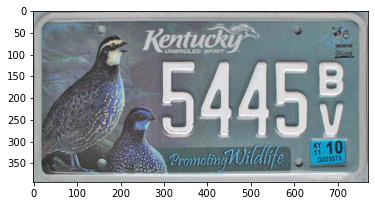

5445


In [51]:
# Mostrar imagen.
plt.figure()
plt.imshow(carImgExperiment)
plt.show()

# Imprimir resultado.
if codeResult == None:
    print("No se pudo leer.")
else:
    print(codeResult)

## Experiment 2 - Predict all images

### Data collection

In [52]:
# Listas a utilizar.
carPlatesCode = []
carPlatesImages = []

# Nombre del folder principal.
folderName0 = 'Experiments datasets'

for folderName1 in os.listdir(folderName0):
    # Folder contenedor de las imágenes de las placas de automóviles.
    if folderName1.startswith("Only car plates images dataset"):
        # Imagen de la placa del automóvil.
        for fileName in os.listdir(folderName0 + '/' + folderName1):
            img = cv2.imread(folderName0 + '/' + folderName1 + '/' + fileName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            carPlatesCode.append(fileName[:-4])
            carPlatesImages.append(img)

### Get predictions for each car plate

In [53]:
# Lista a utilizar.
predictionsByPlate = []

# Por cada placa.
for carPlate in carPlatesImages:
    # Correr el algoritmo para obtener el código de serie de la placa.
    code = GetPlateString(carPlate)
    
    # Validar si se obtuvo un nulo.
    if code == None:
        code = ""
    
    # Añadir a la lista.
    predictionsByPlate.append(code)

### Get the Levenshtein distance between the plate code and its prediction

In [54]:
# Lista a utilizar.
levenshteinDistances  = []

# Por cada placa.
for carPlateCode, carPlateCodePrediction in zip(carPlatesCode, predictionsByPlate):
    levenshteinDistance = lev(carPlateCode, carPlateCodePrediction)
    levenshteinDistances.append(levenshteinDistance)
    
# Convertir a np.
levenshteinDistances = np.asarray(levenshteinDistances)

### Statistical metrics

In [55]:
# Sacar la cantidad de predicciones perfectas (sin ningún error).
perfectPredictionCount = len(levenshteinDistances[levenshteinDistances == 0])

# Sacar la cantidad de predicciones que sólo tuvieron un error.
onePredictionCount = len(levenshteinDistances[levenshteinDistances == 1])

# Impresiones.
print("Cantidad de predicciones perfectas: " + str(perfectPredictionCount))
print("Cantidad de predicciones con 1 error: " + str(onePredictionCount))
print("Promedio: " + str(np.mean(levenshteinDistances)))
print("Desviación estándar: " + str(np.std(levenshteinDistances)))

Cantidad de predicciones perfectas: 80
Cantidad de predicciones con 1 error: 43
Promedio: 0.8389261744966443
Desviación estándar: 1.3111146653480519


### Union of values

In [56]:
# Lista a utilzar.
platePredictionData = []

# Por cada placa.
for carPlateCode, carPlateCodePrediction, levenshteinDistance in zip(carPlatesCode, predictionsByPlate, levenshteinDistances):
    platePredictionData.append([levenshteinDistance, carPlateCode, carPlateCodePrediction])
    
# Convertir en Dataframe.
platePredictionDataDF = pandas.DataFrame(platePredictionData)

# Añadir títulos de columnas.
platePredictionDataDF.columns = ["Levenshtein","Car plate code","Prediction"]

# Ordenar por número de errores. 
platePredictionDataDF = platePredictionDataDF.sort_values(by="Levenshtein")

# Observar Dataframe.
pandas.set_option('display.max_rows', None)
platePredictionDataDF

,Levenshtein,Car plate code,Prediction
0,0,00000,00000
95,0,FUY905,FUY905
94,0,FUENTES,FUENTES
92,0,FL19725,FL19725
91,0,FARTCAN,FARTCAN
88,0,EC8774,EC8774
85,0,DMN112,DMN112
83,0,DL0000,DL0000
81,0,CP021T,CP021T
80,0,CCB116,CCB116
